Copyright (c) 2023 Graphcore Ltd. All rights reserved.

# CLIP for Semantic Search

## Introduction

Semantic search is revolutionizing the way we interact with information retrieval systems. It shifts the focus from keyword matching to understanding the intent and contextual meaning behind a search query. This paradigm allows for more intuitive and relevant results, as the system comprehends queries in a human-like manner. The CLIP (Contrastive Language–Image Pretraining) model, developed by OpenAI, emerges as a cutting-edge tool in this space. CLIP's unique ability to encode both text and images into a shared representation space enables a deep understanding of content, making it ideal for semantic search tasks.

In this tutorial, we will explore how the CLIP model can be utilized for semantic search, beginning with an introduction to the model itself and why it's suited for this task, followed by a deeper dive into the concept of semantics. Later, we will guide you through implementing a fast nearest neighbour search, essential for efficiently retrieving the most semantically relevant results.

## CLIP: Connecting text and images

The CLIP model is a transformative approach that learns visual concepts from natural language supervision.

- Multimodal understanding: CLIP is trained on a diverse range of images and text, enabling it to understand and relate to a wide variety of concepts semantically.

- Zero-shot capabilities: It can perform tasks without any task-specific fine-tuning, making it versatile for semantic search across different domains.

- Shared embedding space: CLIP maps both text and images into a common embedding space, allowing for direct comparison and relevance matching between text queries and image content.



During training, the model uses two encoders: one for images and another for text. The image encoder processes batches of images to produce image embeddings (I₁, I₂, ..., Iₙ), and the text encoder processes the corresponding captions to produce text embeddings (T₁, T₂, ..., Tₙ).

The goal of contrastive learning here is to align the embeddings from the image encoder with the correct embeddings from the text encoder. For each image embedding, the model calculates its similarity with every text embedding in the batch. The pairs of images and their corresponding captions (I₁-T₁, I₂-T₂, ..., Iₙ-Tₙ) should have the highest similarity scores.

The similarities between non-matching image-text pairs (for example, I₁-T₂, I₂-T₃) are also calculated, but these should result in lower scores. This contrast between high similarity for matching pairs and low similarity for non-matching pairs is what trains the model to accurately associate images with relevant text.

The training process uses these similarities to compute a contrastive loss, such as the triplet loss or noise-contrastive estimation. This loss is minimized when the matching image-text pairs have high similarity scores, and non-matching pairs have low similarity scores.

# How to run CLIP on IPUs

Since CLIP checkpoints are available on Hugging Face, you can use the [🤗 `transformers`](https://huggingface.co/docs/transformers/index) library to load the model.

In [1]:
%pip install transformers


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu:
Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import CLIPProcessor, CLIPModel
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")


/opt/pytorch/lib/python3.8/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


To run this model on IPUs, we first set up the IPU options.

The `setAvailableMemoryProportion` option controls how much memory an operation (such as a matmul or convolution) will try to use for temporary values, intermediate sums and so on. It allows us to trade-off between memory and execution time (of operations). The default value is 0.6 i.e. 60% of memory. You can read more about how to set this option in the technical note [Optimising Temporary Memory Usage for Convolutions and Matmuls on the IPU](https://docs.graphcore.ai/projects/available-memory/en/latest/index.html). 

The `replicationFactor` option controls how many data-parallel models to use. For example, our model uses 1 IPU, so we set the `replicationFactor` to 1. If you are using a POD4, then you can set the `replicationFactor` to 4 to use all 4 available IPUs. 

We set:
- `setAvailableMemoryProportion` to 0.1 to ensure that the model fits in the memory of 1 IPU.
- `replicationFactor` to 1 to process a single image.

In [3]:
# To run on IPU we import poptorch package
import poptorch

opts = poptorch.Options()
opts.setAvailableMemoryProportion({"IPU0": 0.1}) #to fit in IPU memory
opts.replicationFactor(1) #this can be set higher to utilize all available IPUs


Options(replication_factor=1, input_group_size=1, input_cgt=<CommGroupType.Consecutive: 1>, broadcast_buffers=True, device_iterations=1, log_dir='.', max_repeat_logs=4, auto_round_num_ipus=False, anchored_tensors={}, output_mode=4, output_return_period=1, connection_type=0, sync_pattern=0, available_memory_proportion={0: 0.1}, Distributed=_DistributedOptions(num_distributed_processes=1, distributed_process_id=0, ipuof_configs={}, _gcd_mappings={}, _warnings={}, _warnings_disabled=set(), _is_frozen=False), Jit=_JitOptions(, _warnings={}, _warnings_disabled=set(), _is_frozen=False), Precision=_PrecisionOptions(, _popart_options=_PopartOptions(instrumentWithHardwareCycleCounter=False, rearrangeAnchorsOnHost=False, cachePath='/tmp/exe_cache/3.3.0', enableEngineCaching=True), _warnings={}, _warnings_disabled=set(), _is_frozen=False), TensorLocations=_TensorLocationOptions(, _warnings={}, _warnings_disabled=set(), _is_frozen=False), Training=_TrainingOptions(gradient_accumulation=1, accumula

The model takes an image and a list of strings as input. 

We can dowload a sample image: http://images.cocodataset.org/val2017/000000039769.jpg
![an image of a cat](http://images.cocodataset.org/val2017/000000039769.jpg)


In [4]:
from PIL import Image
import requests

# download and open an image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

texts=["a big dog sleeping", "two cats sleeping", "two cats on a couch"]

#process the input
inputs = processor(text=texts, images=image, return_tensors="pt", padding=True)


We wrap the model with `poptorch.inferenceModel` to compile a `torch.nn.Model` model for the IPU.

***Warning:*** The first time you run the next cell, the model will be compiled to run on IPUs. This will take approximately 1 minute. Subsequent runs will not trigger a new compilation, and will take less time.

In [5]:
#instantiate inferenceModel() by passing model and poptorch options
clip_on_ipu = poptorch.inferenceModel(model, options=opts)

#run the model
outputs = clip_on_ipu(**inputs) # will compile on first run


Graph compilation: 100%|██████████| 100/100 [00:06<00:00]


To show the result, we use `matplotlib` to display the image and the similarity score for each sentence with the image.

In [6]:
%pip install matplotlib


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu:
Note: you may need to restart the kernel to use updated packages.


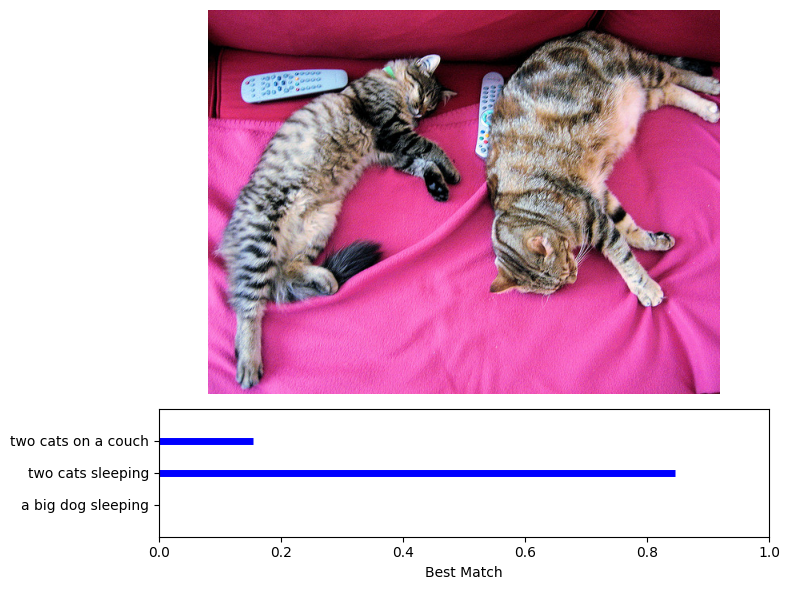

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

scores = outputs.logits_per_image.softmax(dim=1)[0].numpy()

# Create a figure and a set of subplots with adjusted relative heights
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})  # Adjust as needed

# Display the image in the first subplot
axs[0].imshow(image)
axs[0].axis('off')  # Hide the axis for the image

# Plot the probabilities as horizontal lines in the second subplot
for i, prob in enumerate(scores):
    axs[1].hlines(y=i, xmin=0, xmax=prob, color='blue', linewidth=5)
    axs[1].set_yticks(range(len(texts)))
    axs[1].set_yticklabels(texts)
    axs[1].set_ylim(-1, len(texts))  # Adjust for better spacing
    axs[1].set_xlim(0, 1)  # Assuming probability values are between 0 and 1
    axs[1].set_xlabel('Best Match')

plt.tight_layout()
plt.show()


## Semantic search

Semantic search goes beyond mere keyword matching; it's about comprehending the searcher's intent and the contextual meaning of their query. This approach allows search engines to deliver results that are more aligned with what the user is actually seeking.

At its core, semantic search uses natural language processing (NLP) to understand the intent behind a query. Instead of focusing on the literal words typed into the search box, semantic search considers the query's context and nuances.

The CLIP model by OpenAI stands out for its ability to understand both visual and textual content. This makes it especially powerful for semantic search, as it can interpret the meaning behind images and text alike, often capturing subtleties that traditional models might miss.

To incorporate semantics into search with CLIP, the process involves:

- Processing queries: Transforming user queries into a form that the model can understand, which might include recognizing and disambiguating key terms.

- Understanding content: Using the model to generate embeddings that capture the deeper meaning within the database's content.

- Matching: Comparing query embeddings to content embeddings to find the best match based on semantic similarity.

To do so, we will use the model to extract image and text embeddings and create a FAISS index to do the matching.

We first define the image and the text models by isolating the vision part and the text part of the model, with their respective projections:

In [8]:
import torch.nn as nn

class ImageModel(nn.Module):
    """
    Image inference model - use the vision model of CLIP and the visual projection
    """
    def __init__(self):
        super().__init__()
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    def forward(self, pixel_values):
        vision_outputs = self.model.vision_model(pixel_values)
        return self.model.visual_projection(vision_outputs[1])

class TextModel(nn.Module):
    """
    Text inference model - use the text model and the text projection
    """
    def __init__(self):
        super().__init__()
        self.model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

    def forward(self, **kargs):
        text_outputs = self.model.text_model(**kargs)
        return self.model.text_projection(text_outputs[1])


We first need to install [faiss](https://github.com/facebookresearch/faiss) (the CPU version) and the [🤗 `datasets`](https://huggingface.co/docs/datasets/index) library to download some images.

In [9]:
%pip install faiss-cpu datasets


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu:
Note: you may need to restart the kernel to use updated packages.


In this example, we will use the [Human Action Recognition (HAR)](https://huggingface.co/datasets/Bingsu/Human_Action_Recognition) image dataset.

Here, you can use your own dataset or any other image dataset.

In [10]:
from datasets import load_dataset
dataset = load_dataset("Bingsu/Human_Action_Recognition")


In [11]:
clip_on_ipu.detachFromDevice() #detach the previous model to free up IPUs


For each image in the dataset, we extract its embedding representation. 
We can now set the `replicationFactor` to a higher number, to speed up the inference time over the dataset.

You can use : `os.getenv("NUM_AVAILABLE_IPU")` to get the number of available IPUs.

In [27]:
import os
import numpy as np

num_available_ipus=int(os.getenv("NUM_AVAILABLE_IPU", 4))

opts = poptorch.Options() #we instantiate new poptorch options
opts.setAvailableMemoryProportion({"IPU0": 0.1}) #to fit in IPU memory
opts.replicationFactor(num_available_ipus) #this can be set to 4 to utilize all available IPUs

im = poptorch.inferenceModel(ImageModel(), options=opts) # Wrap image model to compile for IPU

def process_batch(batch):
    """
    For each batch, we need to process it and store each output in the new column embeddings
    """
    # Process the images in the batch
    inputs = processor(images=batch['image'], return_tensors="pt")
    
    # Check if padding is necessary
    nb_padding = num_available_ipus - inputs['pixel_values'].shape[0]
    if nb_padding > 0 :
        inputs['pixel_values'] = nn.functional.pad(inputs['pixel_values'],  (0, 0, 0, 0, 0, 0, 0, nb_padding), 'constant', 0)

    # Apply the model and convert to numpy
    embeddings = [output.numpy() for output in im(**inputs)[:num_available_ipus-nb_padding]]
    return {'embeddings': embeddings}

# Apply the function to the dataset in a batched manner
ds_with_embeddings = dataset["test"].map(
    process_batch,
    batched=True,
    batch_size=num_available_ipus
) #should take around one minute and a half with 4 IPUs

im.detachFromDevice()


Map:   0%|          | 0/5400 [00:00<?, ? examples/s]


Graph compilation: 100%|██████████| 100/100 [00:02<00:00]


We use the built-in function `add_faiss_index()` to create the index with the newly created column.

In [28]:
ds_with_embeddings.add_faiss_index(column='embeddings')


  0%|          | 0/6 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'labels', 'embeddings'],
    num_rows: 5400
})

Let's test our approach by choosing a random image from the test dataset and retrieving its closest neighbors.

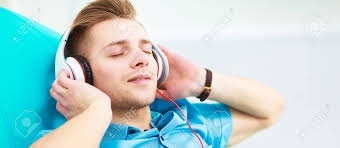

In [29]:
import random

image_test = dataset["test"][random.randint(0, len(dataset["test"]))]["image"]
image_test


In [30]:
opts = poptorch.Options()
opts.setAvailableMemoryProportion({"IPU0": 0.1})
opts.replicationFactor(1)

im = poptorch.inferenceModel(ImageModel(), options=opts)

inputs = processor(images=image_test, return_tensors="pt") #process the input
outputs = im(**inputs) #compute input image embedding
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('embeddings', outputs[0].numpy(), k=10) #find 10 nearest neighbors


Graph compilation: 100%|██████████| 100/100 [00:42<00:00]


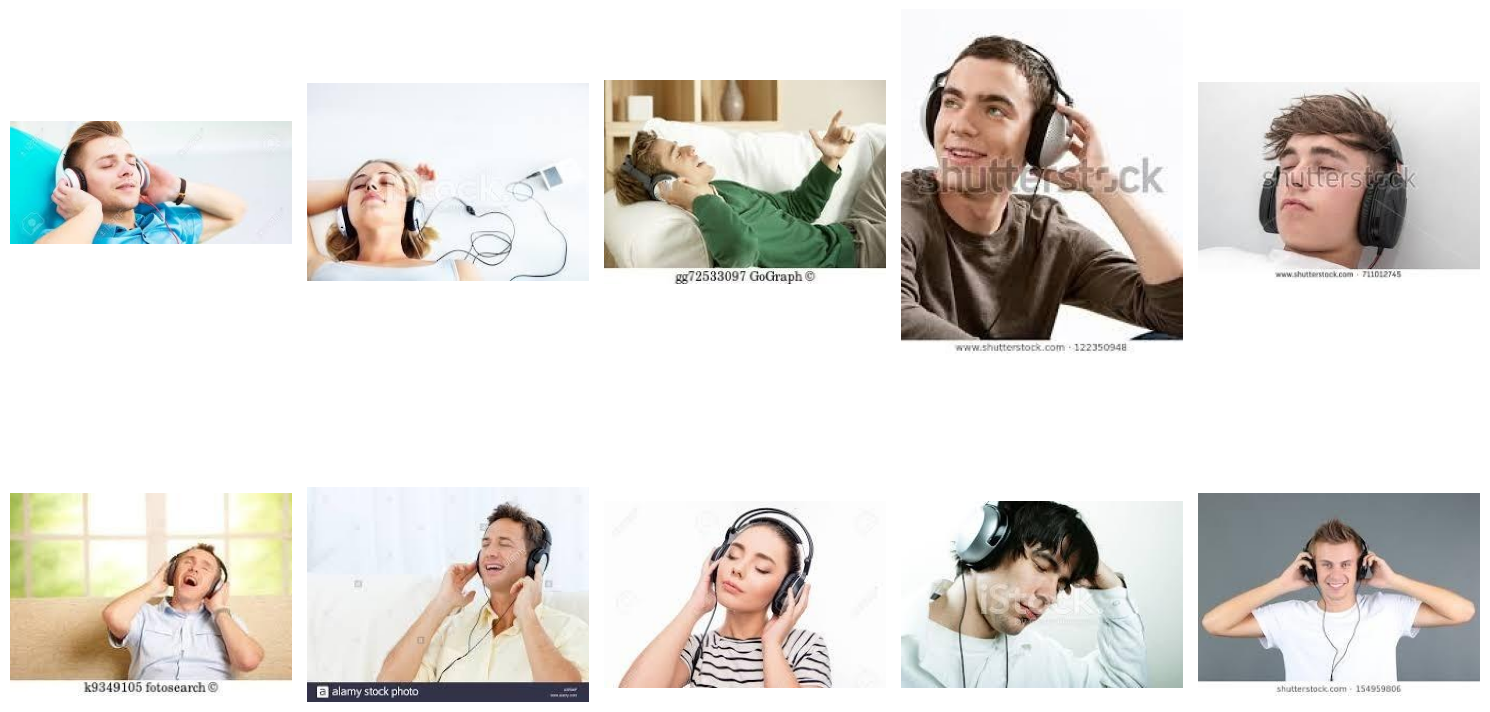

In [31]:
images = retrieved_examples["image"]

# Create a figure and subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 10))

# Flatten the array of axes, for easy iterating
axs = axs.flatten()

for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


We can try the same with some text input:

In [22]:

tm = poptorch.inferenceModel(TextModel(), options=opts)
inputs = processor(text=["a person looking at their phone"], return_tensors="pt")
outputs = tm(**inputs) #this will compile the TextModel the first time it is called, this takes ~30s


Graph compilation: 100%|██████████| 100/100 [00:26<00:00]


In [23]:
scores, retrieved_examples = ds_with_embeddings.get_nearest_examples('embeddings', outputs[0].numpy(), k=10)


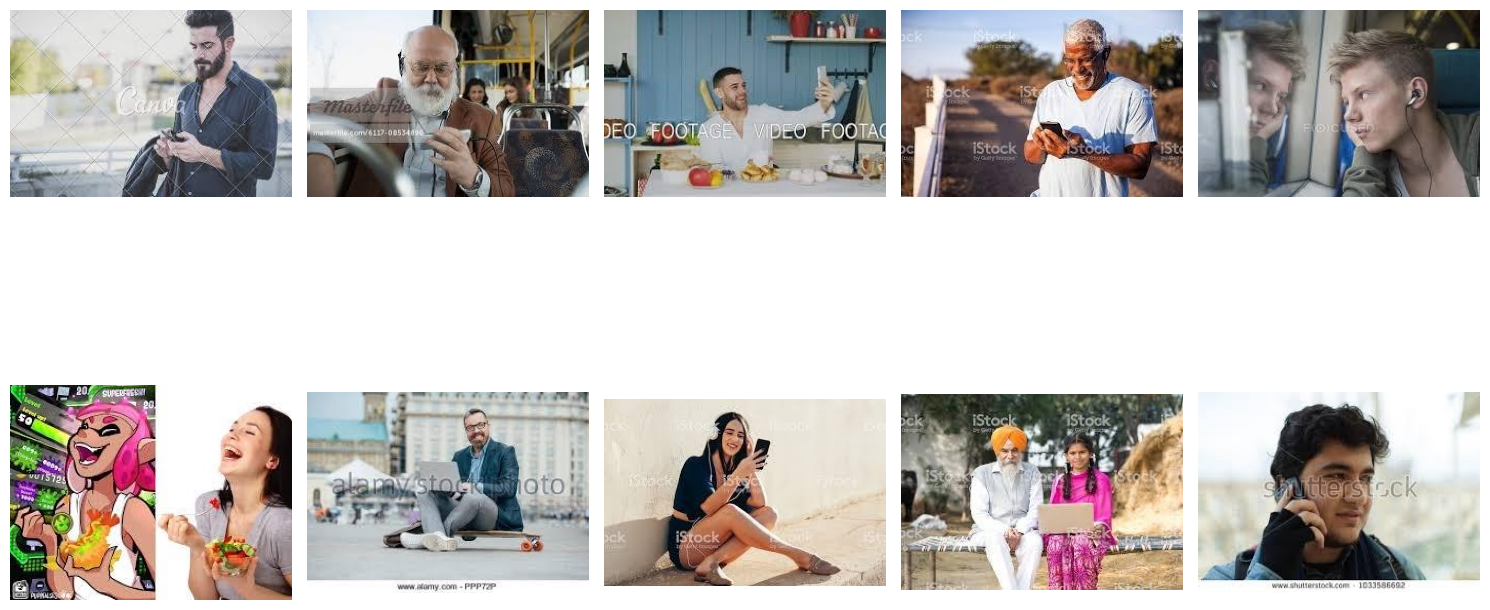

In [24]:
images = retrieved_examples["image"]

# Create a figure and subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 10))  # Adjust the figsize as needed

# Flatten the array of axes, for easy iterating
axs = axs.flatten()

for i, img in enumerate(images):
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes

plt.tight_layout()
plt.show()


## Going further: Fine-tuning the model



A great way to improve results on a specific task is to fine-tune the model. Fine-tuning a model like CLIP with user feedback, such as which images users clicked on, involves a process of retraining the model (or parts of it) using a dataset enriched with this feedback. The goal is to adjust the model's parameters so that it better aligns with users' implicit indications of relevance.

Here's a high-level approach to fine-tuning the CLIP model with user feedback:

- Gather data on user interactions. For instance, when a user searches using a text query and clicks on certain images, log the query, the images displayed, and which images were clicked. This data implies that the clicked images were more relevant to the user's query than those that were not clicked.

- Construct a new dataset where each instance consists of the user's query, the selected (clicked) image, and potentially the images that were not selected. The selected images can be treated as positive examples, while the non-selected images, shown in the same search result, can be used as negative examples.

- Decide on a fine-tuning strategy. You might choose to fine-tune the entire model or only specific layers. For instance, you may only fine-tune the final layers responsible for matching text and image embeddings.

- Modify the training objective to incorporate the feedback. One common approach is to use a ranking loss function that pushes the model to rank clicked (relevant) images higher than non-clicked (irrelevant) images for a given query.



An example of training CLIP on IPU is available on [GitHub](https://github.com/graphcore/examples/blob/master/multimodal/CLIP/pytorch/train.py). 